In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cmapss
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow_probability import distributions
from sklearn.metrics import r2_score

# Load data
data_folder = '/app/data'
data = cmapss.load_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1])

# RUL Prediction as Regression

## RUL Prediction as Regression

**Let's start from _the most straightforward formulation_ of a RUL problem**

* We will predict the RUL using a regression approach
* ...And trigger maintenance when the estimated RUL becomes too low, i.e.:

$$
f(x, \lambda) < \theta
$$

* $f$ is the regressor, with parameter vector $\lambda$
* The threshold $\theta$ must account for possible estimation errors

**We will focus on the hardest of the four datasets (to reduce training times):**

In [4]:
data_by_src = cmapss.split_by_field(data, field='src')
dt = data_by_src['train_FD004']

## Training and Test Data

**We now need to define our training and test data**

In a practical setting:

* Some run-to-failure experiments will form the training set
* Others run-to-failure experiments will be used for testing

I.e. we split _whole experiments_ rather than individual examples! 

**Each run-to-failure experiment in our data is associated to a machine**

Let's check how many we have:

In [5]:
print(f'Number of machines: {len(dt.machine.unique())}')

Number of machines: 249


* This is actually a very large number
* In most practical setting, _much fewer_ experiments will be available

## Training and Test Data

**Let's use 75% of the machine for training, the rest for testing**

First, we partition the machine indexes:

In [6]:
tr_ratio = 0.75
np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]

Then, we partition the dataset itself (via a helper function):

In [7]:
tr, ts = cmapss.partition_by_machine(dt, tr_mcn)

## Training and Test Data

**Let's have a look at the training data**

In [8]:
tr

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,train_FD004,461,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,train_FD004,461,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,train_FD004,461,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,train_FD004,461,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60989,train_FD004,708,180,35.0019,0.8409,100.0,449.44,556.28,1377.65,1148.96,...,2387.77,8048.91,9.4169,0.02,337,2223,100.00,14.66,8.7446,4
60990,train_FD004,708,181,0.0023,0.0000,100.0,518.67,643.95,1602.98,1429.57,...,2388.27,8122.44,8.5242,0.03,396,2388,100.00,38.40,23.1079,3
60991,train_FD004,708,182,25.0030,0.6200,60.0,462.54,536.88,1268.01,1067.09,...,2027.98,7865.18,10.9790,0.02,309,1915,84.93,14.24,8.4254,2
60992,train_FD004,708,183,41.9984,0.8414,100.0,445.00,550.64,1363.76,1145.72,...,2387.48,8069.84,9.4607,0.02,333,2212,100.00,10.37,6.2727,1


## Training and Test Data

**...And at the test data**

In [9]:
ts

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
321,train_FD004,462,1,41.9998,0.8400,100.0,445.00,548.99,1341.82,1113.16,...,2387.98,8082.37,9.3300,0.02,331,2212,100.00,10.77,6.2894,298
322,train_FD004,462,2,9.9999,0.2500,100.0,489.05,604.23,1498.00,1299.54,...,2388.07,8125.46,8.6088,0.03,368,2319,100.00,28.61,17.3135,297
323,train_FD004,462,3,42.0079,0.8403,100.0,445.00,549.11,1351.47,1126.43,...,2387.93,8082.11,9.2965,0.02,330,2212,100.00,10.70,6.4288,296
324,train_FD004,462,4,42.0077,0.8400,100.0,445.00,548.77,1345.81,1116.64,...,2387.88,8079.41,9.3200,0.02,330,2212,100.00,10.50,6.2818,295
325,train_FD004,462,5,24.9999,0.6200,60.0,462.54,537.00,1259.55,1043.95,...,2028.13,7867.08,10.8841,0.02,307,1915,84.93,14.26,8.5789,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,train_FD004,709,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,...,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234,4
61245,train_FD004,709,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,...,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151,3
61246,train_FD004,709,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,...,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270,2
61247,train_FD004,709,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,...,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774,1


## Standardization/Normalization

**Now, we need to make the range of each columns more uniform**

We will _standardize_ all parameters and sensor inputs:

In [10]:
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields

ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

We will _normalize_ the RUL values (i.e. our regression target)

In [12]:
trmaxrul = tr['rul'].max()

ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 

## Standardization/Normalization

**Let's check the results**

In [13]:
tr_s.describe()

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,45385.000000,45385.000000,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,...,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,45385.000000
mean,582.490955,133.323896,2.894775e-16,1.302570e-16,1.178889e-16,4.664830e-15,2.522791e-15,1.727041e-15,-6.633794e-16,1.496703e-16,...,1.135835e-15,-6.017186e-15,-1.409030e-16,-1.058182e-15,-6.532030e-16,1.583594e-16,-3.093135e-15,2.572263e-16,-1.477916e-16,0.244140
std,71.283034,89.568561,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.165256
min,461.000000,1.000000,-1.623164e+00,-1.838222e+00,-2.381839e+00,-1.055641e+00,-1.176507e+00,-1.646830e+00,-1.486984e+00,-1.138606e+00,...,-2.387561e+00,-2.583315e+00,-1.480340e+00,-6.950269e-01,-1.644539e+00,-2.151433e+00,-2.381839e+00,-1.077489e+00,-1.079308e+00,0.000000
25%,521.000000,62.000000,-9.461510e-01,-1.031405e+00,4.198344e-01,-1.055641e+00,-8.055879e-01,-6.341243e-01,-6.912917e-01,-1.138606e+00,...,4.181950e-01,-5.977256e-02,-8.501637e-01,-6.950269e-01,-6.379310e-01,-1.126840e-01,4.198344e-01,-9.979498e-01,-9.988926e-01,0.112546
50%,585.000000,123.000000,6.868497e-02,4.154560e-01,4.198344e-01,-3.917563e-01,-6.336530e-01,-4.718540e-01,-5.429267e-01,-2.714913e-01,...,4.194408e-01,1.862163e-01,-4.025983e-02,-6.950269e-01,-4.941298e-01,-3.717480e-02,4.198344e-01,-5.972306e-01,-5.971843e-01,0.225092
75%,639.000000,189.000000,1.218855e+00,8.661917e-01,4.198344e-01,6.926385e-01,7.407549e-01,7.495521e-01,8.439630e-01,6.867534e-01,...,4.202973e-01,7.086220e-01,1.055441e-01,1.438762e+00,7.641306e-01,6.561373e-01,4.198344e-01,7.740747e-01,7.744926e-01,0.346863
max,708.000000,543.000000,1.219524e+00,8.726308e-01,4.198344e-01,1.732749e+00,1.741030e+00,1.837978e+00,2.000975e+00,1.818973e+00,...,4.383623e-01,2.264997e+00,2.365107e+00,1.438762e+00,1.806689e+00,1.095464e+00,4.198344e-01,1.915822e+00,1.907272e+00,1.000000


## Regression Model

**We can now define a regression model**

We will use a feed-forward neural network (MLP):

In [14]:
def build_regressor(hidden):
    input_shape = (len(dt_in), )
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    model_out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(model_in, model_out)
    return model

* The `hidden` argument is a list of sizes for the hidden layers
* ...E.g. `hidden = [64, 32]`
* By setting `hidden=[]` we obtain a simple Linear Regression approach

## Training

**We can now train our model**

In [15]:
nn = build_regressor(hidden=[])
nn.compile(optimizer='Adam', loss='mse')
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = nn.fit(tr_s[dt_in], tr_s['rul'], validation_split=0.2,
                 callbacks=cb, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1135/1135 [==============================] - 1s 606us/step - loss: 0.0607 - val_loss: 0.0266
Epoch 2/20
1135/1135 [==============================] - 1s 510us/step - loss: 0.0254 - val_loss: 0.0188
Epoch 3/20
1135/1135 [==============================] - 1s 520us/step - loss: 0.0207 - val_loss: 0.0166
Epoch 4/20
1135/1135 [==============================] - 1s 516us/step - loss: 0.0187 - val_loss: 0.0153
Epoch 5/20
1135/1135 [==============================] - 1s 521us/step - loss: 0.0175 - val_loss: 0.0139
Epoch 6/20
1135/1135 [==============================] - 1s 510us/step - loss: 0.0166 - val_loss: 0.0132
Epoch 7/20
1135/1135 [==============================] - 1s 515us/step - loss: 0.0160 - val_loss: 0.0126
Epoch 8/20
1135/1135 [==============================] - 1s 508us/step - loss: 0.0155 - val_loss: 0.0128
Epoch 9/20
1135/1135 [==============================] - 1s 442us/step - loss: 0.0152 - val_loss: 0.0118
Epoch 10/20
1135/1135 [==============================] - 0s 434u

## Training

**Here's the loss evolution over time and its final value**

Final loss: 0.0143 (training), 0.0106 (validation)


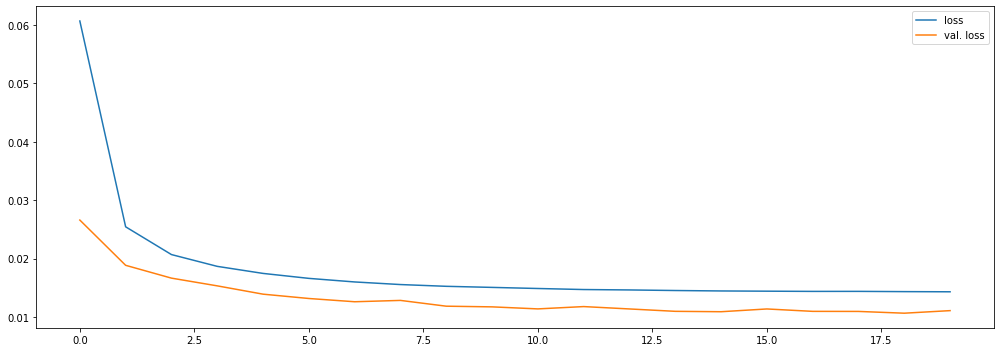

In [16]:
cmapss.plot_training_history(history, figsize=figsize)
trl, vll = history.history["loss"][-1], np.min(history.history["val_loss"])
print(f'Final loss: {trl:.4f} (training), {vll:.4f} (validation)')

## Training

**Let's try with a more complex model**

In [17]:
nn = build_regressor(hidden=[32, 32])
nn.compile(optimizer='Adam', loss='mse')
history = nn.fit(tr_s[dt_in], tr_s['rul'], validation_split=0.2,
                 callbacks=cb, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1135/1135 [==============================] - 1s 687us/step - loss: 0.0216 - val_loss: 0.0126
Epoch 2/20
1135/1135 [==============================] - 1s 622us/step - loss: 0.0151 - val_loss: 0.0115
Epoch 3/20
1135/1135 [==============================] - 1s 624us/step - loss: 0.0150 - val_loss: 0.0117
Epoch 4/20
1135/1135 [==============================] - 1s 624us/step - loss: 0.0145 - val_loss: 0.0127
Epoch 5/20
1135/1135 [==============================] - 1s 627us/step - loss: 0.0144 - val_loss: 0.0122
Epoch 6/20
1135/1135 [==============================] - 1s 623us/step - loss: 0.0144 - val_loss: 0.0109
Epoch 7/20
1135/1135 [==============================] - 1s 634us/step - loss: 0.0141 - val_loss: 0.0111
Epoch 8/20
1135/1135 [==============================] - 1s 628us/step - loss: 0.0141 - val_loss: 0.0105
Epoch 9/20
1135/1135 [==============================] - 1s 630us/step - loss: 0.0140 - val_loss: 0.0106
Epoch 10/20
1135/1135 [==============================] - 1s 556u

## Training

**Let's check the loss behavior and compare it to Linear Regression**

Final loss: 0.0135 (training), 0.0104 (validation)


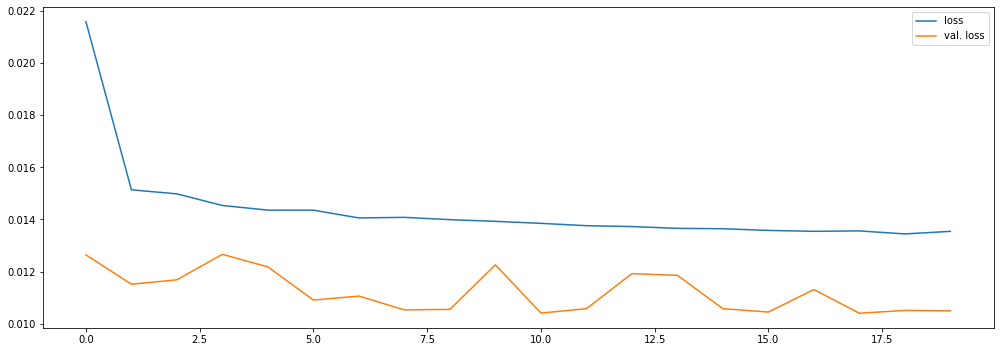

In [18]:
cmapss.plot_training_history(history, figsize=figsize)
trl, vll = history.history["loss"][-1], np.min(history.history["val_loss"])
print(f'Final loss: {trl:.4f} (training), {vll:.4f} (validation)')

* There is some improvement w.r.t. pure Linear Regression

## Predictions

**We can now obtain the predictions and evaluate their quality**

R2 score: 0.5425721983671121


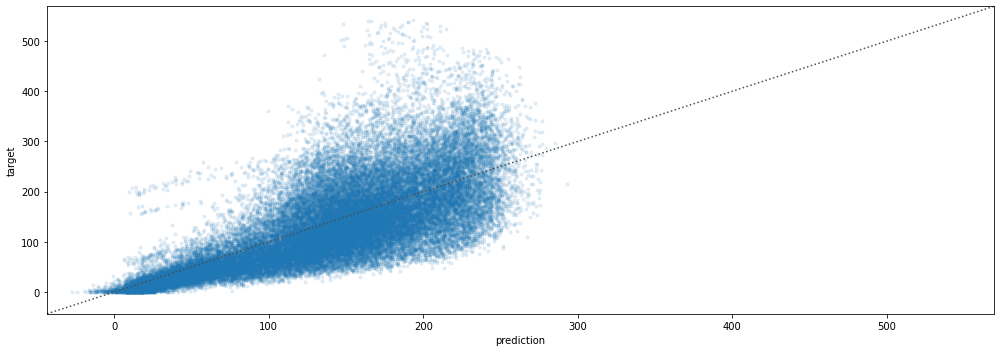

In [19]:
tr_pred = nn.predict(tr_s[dt_in]).ravel() * trmaxrul
cmapss.plot_pred_scatter(tr_pred, tr['rul'], figsize=figsize)
print(f'R2 score: {r2_score(tr["rul"], tr_pred)}')

## Predictions

**The results so far are not comforting**

...But it's worth seeing what is going on over time:

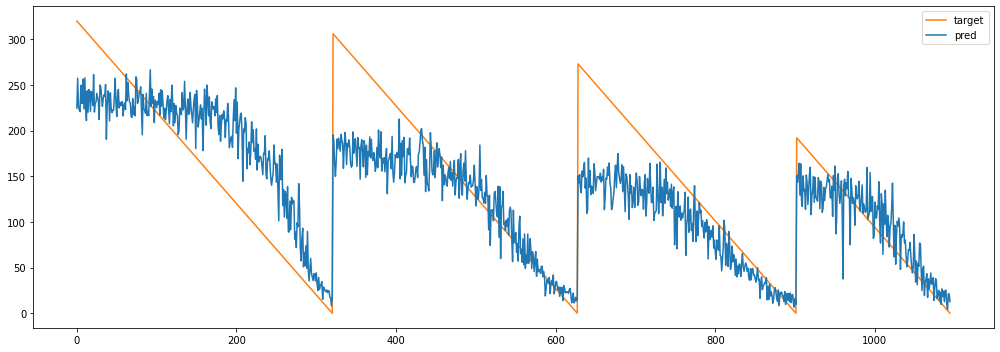

In [20]:
stop = 1095
cmapss.plot_rul(tr_pred[:stop], tr['rul'][:stop], figsize=figsize)

## Predictions

**The situation is similar on the test set:**

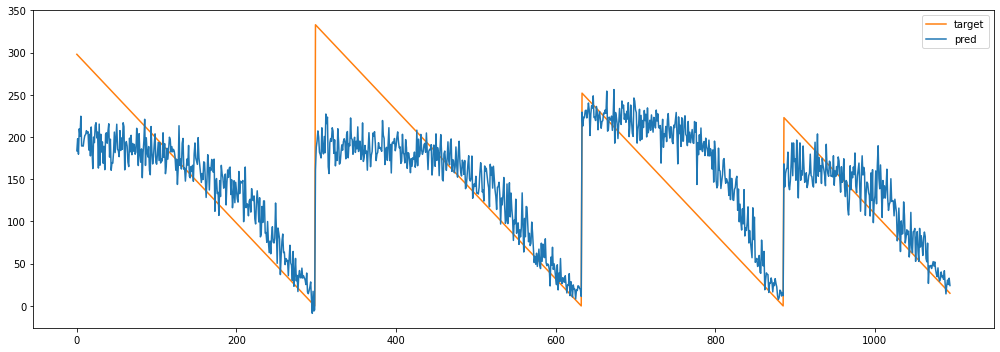

In [21]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul
cmapss.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=figsize)

## Quality Evaluation

**Let's try to recap the situation**

* Our accuracy is quite poor
* ...Especially for large RUL values

**Possible reasons:**

* Large RUL value are somewhat scarce on the dataset
* Fault effects become noticeable only after a while

**But perhaps we don't care! Our goal is _not a high accuracy_**

* We just need to _stop at the right time_
* ...And our model may still be good enough for that

> **For a proper evaluation, we need a _cost model_**

## Cost Model

**We will assume that:**

* Whenever a turbine operates for a time step, we gain a profit of 1 unit
* A failure costs $C$ units (i.e. the equivalent of $C$ operation days)
* We never trigger maintenance before $s$ time steps

**Let $x_k$ be the times series for machine $k$, and $I_k$ its set of time steps**

With our RUL based policy:

* The time step when we trigger maintenance is given by:
$$
\min \{i \in I_k \mid f(x_{ki}) < \theta\}
$$
* A failure occurs if:
$$
f(x_{ki}) \geq \theta \quad \forall i \in I_k
$$

## Cost Model

**The whole cost formula _for a single machine_ will be:**

$$
\mathit{cost}(f, {x_k}, \theta) = \mathit{op\_profit}(f(x_k), \theta) + \mathit{fail\_cost}(f(x_k), \theta)
$$

Where:

$$
\mathit{op\_profit}(f(x_k), \theta) = -\max(0, \min \{i \in I_k \mid f(x_{ki}) < \theta\}-s) \\
\mathit{fail\_cost}(f(x_k), \theta) = \left\{
\begin{align}
& C \text{ if } f(x_{ki}) \geq \theta \quad \forall i \in I_k \\
& 0 \text{ otherwise}
\end{align}
\right.
$$

* $s$ units of machine operation are guaranteed
* ...So we gain over the default policy only if we stop after that
* Profit is modeled as a negative cost

**For the total cost, we need to sum over all machines**

## Cost Model

**Normally, we would proceed as follows**

* $s$ is determined by the fixed maintenance schedule
* $C$ must be determined by discussing with the customer

In our example, we will derive both from data

**First, we collect all failure times**

In [22]:
failtimes = dt.groupby('machine')['cycle'].max()
failtimes.head()

machine
461    321
462    299
463    307
464    274
465    193
Name: cycle, dtype: int64

## Cost Model

**Then, we define $s$ and $C$ based on statistics**

In [23]:
print(failtimes.describe())
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

count    249.00000
mean     245.97992
std       73.11080
min      128.00000
25%      190.00000
50%      234.00000
75%      290.00000
max      543.00000
Name: cycle, dtype: float64


* For the safe interval $s$, we choose the minimum failure time
* For the maintenance cost $C$ we choose the largest failure time

## Threshold Choice

**We can then choose the threshold $\theta$ as usual**

Optimal threshold for the training set: 14


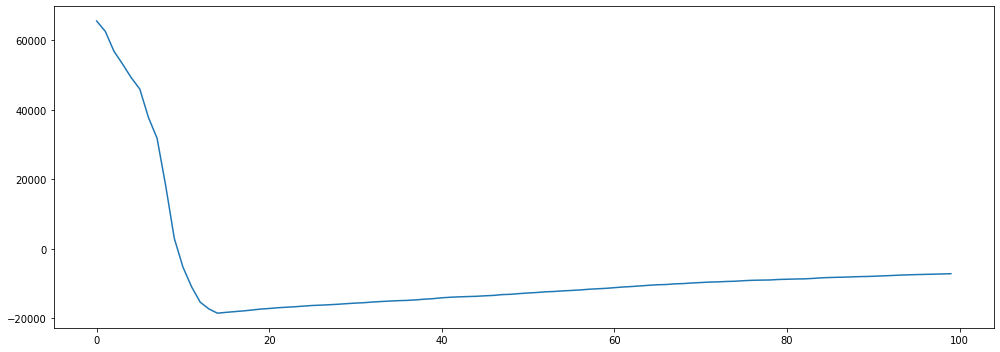

In [26]:
cmodel = cmapss.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(0, 100)
tr_thr = cmapss.opt_threshold_and_plot(tr['machine'].values, tr_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr}')

## Evaluation

**Let's see how we fare in terms of cost**

In [40]:
tr_c, tr_f, tr_sl = cmodel.cost(tr['machine'].values, tr_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, tr_thr, return_margin=True)
print(f'Cost: {tr_c} (training), {ts_c} (test)')

Cost: -18474 (training), -6298 (test)


We can also evaluate the margin for improvement:

In [41]:
print(f'Avg. fails: {tr_f/len(tr_mcn)} (training), {ts_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.0 (training), 0.015873015873015872 (test)
Avg. slack: 16.87 (training), 14.03 (test)


* Slack = distance between when we stop and the failure
* The results are actually quite good!
* ...And we also generalize fairly well

# Sequence Input in Neural Models

## Sequence Input in Neural Models

**Feeding more time steps to our NN may improve the results**

* Intuitively, sequences provide information about the _trend_
* This may allow a better RUL estimate w.r.t. using only the current state
* E.g. we may gauge how quickly the component is deteriorating

**We will try to build a model capable to processing such input**

But first, we need to apply a sliding window:

In [30]:
wlen = 3
tr_sw, tr_sw_m, tr_sw_r = cmapss.sliding_window_by_machine(tr_s, wlen, dt_in)
ts_sw, ts_sw_m, ts_sw_r = cmapss.sliding_window_by_machine(ts_s, wlen, dt_in)

* This must be done on a _per machine_ basis
* Windows _should not mix data_ belonging to different machines!

## Sliding Window for Multivariate Data

**The `sliding_window_by_machine` relies internally on:**

```python
def sliding_window_2D(data, wlen, stride=1):
    # Get shifted _tables_
    m = len(data)
    lt = [data.iloc[i:m-wlen+i+1:stride, :].values for i in range(wlen)]
    # Reshape to _add a new axis_
    s = lt[0].shape
    for i in range(wlen):
        lt[i] = lt[i].reshape(s[0], 1, s[1])
    # Concatenate
    wdata = np.concatenate(lt, axis=1)
    return wdata
```

* It's similar to our code for the univariate case
* The output is a tensor with shape `(n_windows, w_len, n_dims)`

## Sliding Window for Multivariate Data

**Let's look in deeper detail at the returned data structures**

`tr_sw` contain the actual sliding window data:

In [29]:
tr_sw[0]

array([[ 1.21931469,  0.86619169,  0.41983436, -1.05564063, -0.79621447,
        -0.70080293, -0.74549387, -1.1386061 , -1.08249848, -0.99389823,
        -0.11421637, -0.6315044 , -0.67586863, -0.36411574, -0.98910425,
         0.41889575,  0.08700467,  0.05991388, -0.69502688, -0.63793104,
        -0.11268403,  0.41983436, -1.03117521, -1.03187757],
       [-0.26962527,  0.41609996,  0.41983436,  0.6926385 ,  0.71397375,
         0.56288953,  0.29808726,  0.36365649,  0.3710279 ,  0.33249075,
         0.65388538,  0.56210134, -0.20641916,  0.32893584,  0.33156802,
         0.41687122, -0.24758681, -0.12925879, -0.69502688,  0.47652818,
         0.65613725,  0.41983436,  0.35321893,  0.35869109],
       [ 1.21924025,  0.86908928,  0.41983436, -1.05564063, -0.8157647 ,
        -0.70372248, -0.7109787 , -1.1386061 , -1.08433606, -0.98831315,
        -0.11380415, -0.64524209, -0.67586863, -0.37335643, -0.99026013,
         0.41874002, -0.00870947,  0.14931194, -0.69502688, -0.67388133,
  

* 3 times steps per example
* 24 dimensions per time step

## Sliding Window for Multivariate Data

**Let's look in deeper detail at the returned data structures**

`tr_sw_m` contains the corresponding machine values

In [32]:
tr_sw_m

array([461, 461, 461, ..., 708, 708, 708], dtype=int64)

* The structure is a plain numpy array

`tr_sw_r` contains the RUL values

In [33]:
tr_sw_r

array([0.58671587, 0.58487085, 0.58302583, ..., 0.00369004, 0.00184502,
       0.        ])

* Again, the structure is a plain numpy array

## 1D Convolutions in Keras

**The chosen format is ideal for _1D convolutions_ in keras**

We can define a simple 1D convolutional NN as follows:

In [34]:
def build_cnn_regressor(wlen):
    input_shape = (wlen, len(dt_in))
    model_in = keras.Input(shape=input_shape, dtype='float32')
    model_out = layers.Conv1D(32, kernel_size=3, activation='relu')(model_in)
    model_out = layers.Flatten()(model_out)
    model_out = layers.Dense(32, activation='relu')(model_out)
    model_out = layers.Dense(1, activation='linear')(model_out)
    model = keras.Model(model_in, model_out)
    return model

* For simplicity, we consider a fixed architecture
* Each convolution in this case will consider 3 time steps
* We need to "flatten" the input before the fully connected layers
  - Flattening = getting rid of the temporal structure

## CNN Training

**Let's train our CNN**

In [35]:
nn2 = build_cnn_regressor(wlen)
nn2.compile(optimizer='Adam', loss='mse')
history2 = nn2.fit(tr_sw, tr_sw_r, validation_split=0.2,
                 callbacks=cb,
                 batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1126/1126 [==============================] - 1s 711us/step - loss: 0.0247 - val_loss: 0.0174
Epoch 2/20
1126/1126 [==============================] - 1s 643us/step - loss: 0.0168 - val_loss: 0.0127
Epoch 3/20
1126/1126 [==============================] - 1s 645us/step - loss: 0.0156 - val_loss: 0.0125
Epoch 4/20
1126/1126 [==============================] - 1s 643us/step - loss: 0.0149 - val_loss: 0.0120
Epoch 5/20
1126/1126 [==============================] - 1s 649us/step - loss: 0.0146 - val_loss: 0.0109
Epoch 6/20
1126/1126 [==============================] - 1s 648us/step - loss: 0.0142 - val_loss: 0.0113
Epoch 7/20
1126/1126 [==============================] - 1s 645us/step - loss: 0.0140 - val_loss: 0.0109
Epoch 8/20
1126/1126 [==============================] - 1s 646us/step - loss: 0.0139 - val_loss: 0.0111
Epoch 9/20
1126/1126 [==============================] - 1s 653us/step - loss: 0.0137 - val_loss: 0.0108
Epoch 10/20
1126/1126 [==============================] - 1s 656u

## CNN Training

**Let's check the loss behavior and compare it to the MLP model**

Final loss: 0.0129 (training), 0.0100 (validation)


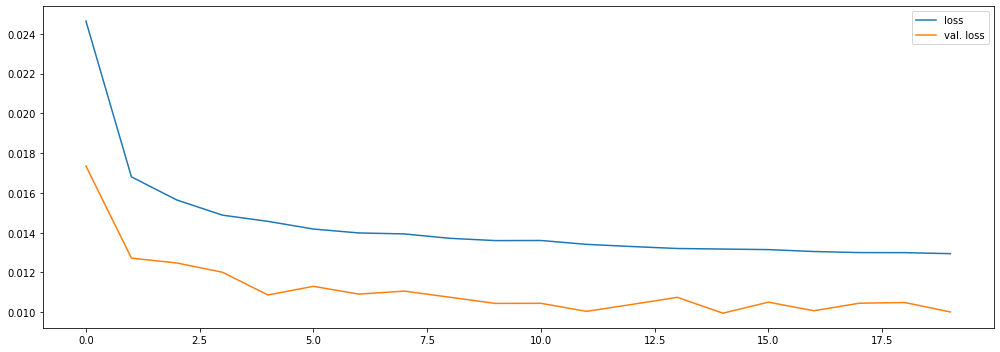

In [36]:
cmapss.plot_training_history(history2, figsize=figsize)
trl2, vll2 = history2.history["loss"][-1], np.min(history2.history["val_loss"])
print(f'Final loss: {trl2:.4f} (training), {vll2:.4f} (validation)')

* Not a lot of improvement, apparently, but some!

## Threshold Optimization

**Now we can proceed by choosing a threshold**

Optimal threshold for the training set: 9


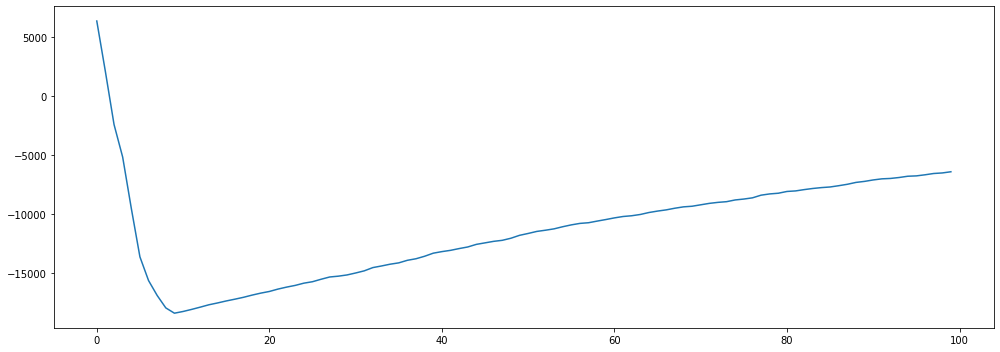

In [37]:
tr_pred2 = nn2.predict(tr_sw).ravel() * trmaxrul
ts_pred2 = nn2.predict(ts_sw).ravel() * trmaxrul
tr_thr2 = cmapss.opt_threshold_and_plot(tr_sw_m, tr_pred2, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr2}')

## Evaluation

**Let's see how the CNN fares in terms of cost**

In [38]:
tr_c2, tr_f2, tr_sl2 = cmodel.cost(tr_sw_m, tr_pred2, tr_thr2, return_margin=True)
ts_c2, ts_f2, ts_sl2 = cmodel.cost(ts_sw_m, ts_pred2, tr_thr2, return_margin=True)
print(f'Cost: {tr_c2} (training), {ts_c2} (test)')
print(f'Avg. fails: {tr_f2/len(tr_mcn)} (training), {ts_f2/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_sl2/len(tr_mcn):.2f} (training), {ts_sl2/len(ts_mcn):.2f} (test)')

Cost: -18439 (training), -6866 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 15.09 (training), 12.83 (test)


Which is (more or less) on par with our MLP approach, for which we had:

In [39]:
print(f'Cost: {tr_c} (training), {ts_c} (test)')
print(f'Avg. fails: {tr_f/len(tr_mcn)} (training), {ts_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Cost: -18474 (training), -6298 (test)
Avg. fails: 0.0 (training), 0.015873015873015872 (test)
Avg. slack: 16.87 (training), 14.03 (test)


## Considerations and Take-Home Messages

**A first approach for RUL-based maintenance policies**

* Build a RUL predictor
* Trigger maintenance when the prediction is below a threshold
* In practice: a simple two-stage sequential optimization process

**Don't evaluate the performance in term of accuracy: it's a trap!**

* We don't care about accuracy when the RUL is high
* We only care about when we stop
* We need a _cost model_

**Sequence input may help**

* But don't automatically jump for that!
* First _think_: would considering multiple step provide more useful information?